# Imports

In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 8.6 MB/s 
     |████████████████████████████████| 106 kB 78.7 MB/s 


In [676]:
import matplotlib.pyplot as plot
import contractions
import pandas as pd
import re

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [686]:
df = pd.read_excel('/content/season_13.xlsx')

In [687]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Start', axis=1)
df = df.drop('End', axis=1)

# Data exploration

In [688]:
df['Labels'] = df['PP'].astype(str) + ' ' + df['SP'].astype(str) + ' ' + df['MC'].astype(str)

In [689]:
# There are a few combinations to be fixed, like 2 6 0 

value_counts = df['Labels'].value_counts()
print(value_counts[value_counts < 2])

2 6 0    1
0 3 0    1
1 1 4    1
0 6 6    1
0 0 3    1
2 3 1    1
6 0 6    1
Name: Labels, dtype: int64


In [690]:
# Fixing the labels

df.loc[351,'SP'] = [4]
df.loc[462,'PP'] = [3]
df.loc[221,'SP'] = [0]
df.loc[168,'MC'] = [6] 
df.loc[973,'PP'] = [0] 
df.loc[973,'MC'] = [0] 

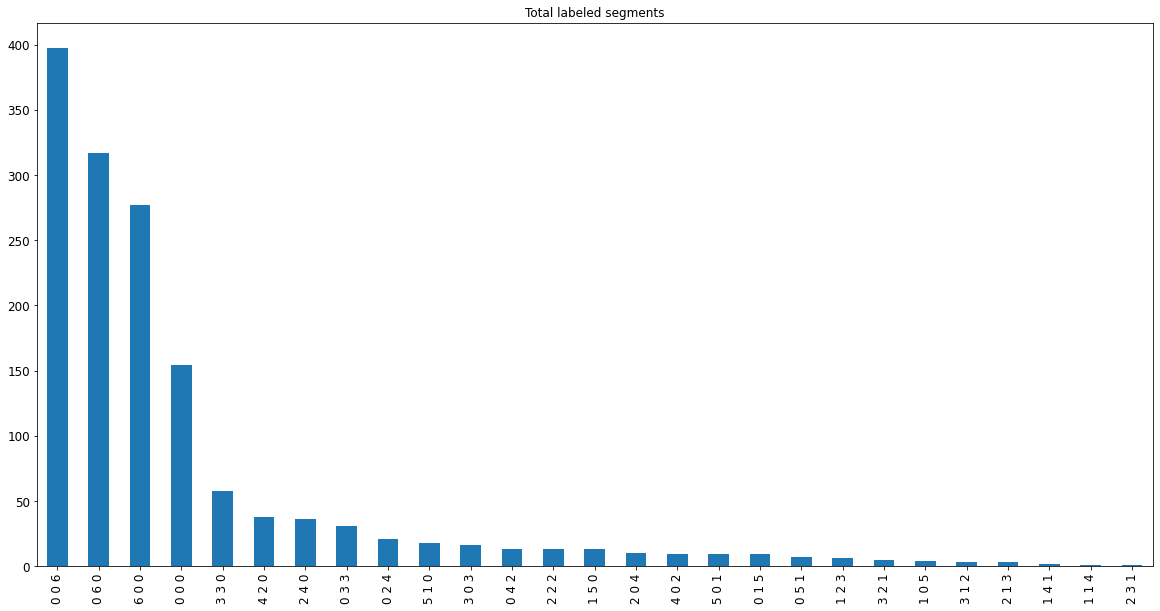

In [691]:
# Total labeled segments

df['Labels'] = df['PP'].astype(str) + ' ' + df['SP'].astype(str) + ' ' + df['MC'].astype(str)
df['Labels'].value_counts().plot(kind='bar', figsize=(20, 10), fontsize=12, title='Total labeled segments');

In [692]:
# Splitting subtitles and counting tokens

df['Subtitle'] = df['Subtitle'].str.split()
df['TokenCount'] = df['Subtitle'].apply(lambda x: len(x))
df['Subtitle'] = df['Subtitle'].str.join(' ')

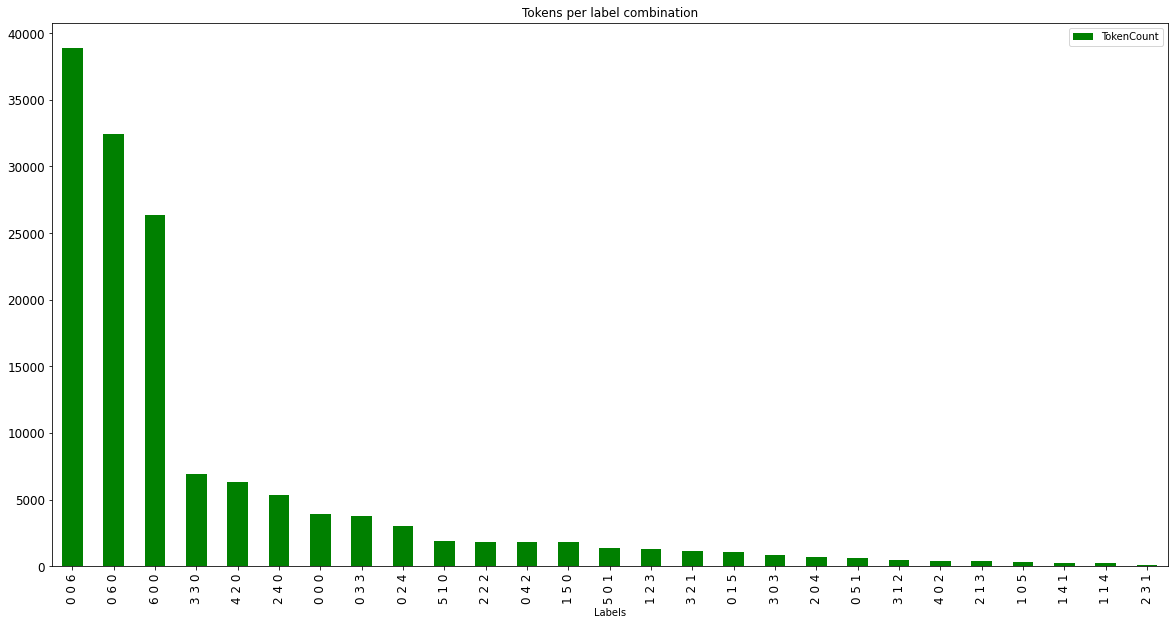

In [693]:
# Token count for each label combination

df2 = df.groupby('Labels').sum()
df2 = df2.reset_index()
df2 = df2.sort_values(by='TokenCount', ascending=False)
df2[['Labels','TokenCount']].plot(x='Labels', y='TokenCount', kind='bar', figsize=(20, 10), legend=True, fontsize=12, color='green', title='Tokens per label combination');

In [694]:
df = df.drop('Labels', axis=1)
df = df.drop('TokenCount', axis=1)

# Preprocessing

In [695]:
# Removing symbols

symbols_regex = '♪(.*?)♪'
symbols_regex2 = '♪'
symbols_regex3 = '<i>'
symbols_regex4 = '</i>'
symbols_regex5 = '- '

df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(symbols_regex, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(symbols_regex2, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(symbols_regex3, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(symbols_regex4, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(symbols_regex5, '', x))

In [696]:
# Fixing contractions

df['Subtitle'] =df['Subtitle'].apply(lambda x: contractions.fix(str(x)))

In [697]:
# Removing boilerplates

boilerplate_regex = 'Synced & corrected by -robtor[-]?'
boilerplate_regex2 = 'Synced & corrected by -robtor- | Resync by Alice www.addic7ed.com'
boilerplate_regex3 = 'www.addic7ed.com'

df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(boilerplate_regex, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(boilerplate_regex2, '', x))
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(boilerplate_regex3, '', x))

In [698]:
# Removing speakers' names

name_regex = '[A-Z][a-z]+\: '
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(name_regex, '', x))

In [699]:
# Removing [sounds]

sounds_regex = '\[.*?\]'
df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(sounds_regex, '', x))

In [700]:
# Removing all punctuation

# df['Subtitle'] = df['Subtitle'].str.replace('[^\w\s]',' ', regex=True)

# Removing all punctuation except hyphens and apostrophes 

df['Subtitle'] = df['Subtitle'].str.replace('[^a-zA-Z0-9 :\-\']',' ', regex=True)

In [701]:
# Removing filler words

filler_words = ['Aah', 'Aaaaaaah', 'Aaaahh', 'aah', 'Ah', 'ah', 'Um', 'um', 'Wow', 
                'wow', 'Uh', 'uh', 'Uh-huh', 'uh-huh', 'Huh', 'huh', 'Ugh', 'ugh', 
                'Oh', 'oh', 'Ooh', 'oooh', 'Hey', 'hey', 'Mnh', 'mnh', 'Mm-hmm', 
                'mm-hmm', 'Mm', 'mm', 'Hmm', 'hmm', 'Hm', 'Mnhmnh', 'Yeah', 'yeah', 
                'Y-Yeah' 'Ow', 'Y-yeah', 'ow', 'Who-o-o-o-a', 'Whoa', 'whoa', 'Okay', 
                'okay', 'N-o-o', 'O-Okay', 'Mwah', 'Huh', 'huh']

df['Subtitle'] = df['Subtitle'].apply(lambda x: ' '.join([word for word in x.split() if word not in (filler_words)]))

In [702]:
# Removing stopwords

stop = stopwords.words('english')
df['Subtitle'] = df['Subtitle'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [703]:
# Lowercasing

df['Subtitle'] = df['Subtitle'].str.lower()

In [704]:
# Removing double spaces

df['Subtitle'] = df['Subtitle'].apply(lambda x: re.sub(' +', ' ', x))

In [705]:
# Updating TokenCount and removing rows shorter than 2 (or any other threshold)

df['Subtitle'] = df['Subtitle'].str.split()
df['TokenCount'] = df['Subtitle'].apply(lambda x: len(x))
df['Subtitle'] = df['Subtitle'].str.join(' ')
df = df[(df['TokenCount'] >= 2)]

In [706]:
# Dropping rows with label combinations that appear only once 

df['Labels'] = df[['PP', 'SP', 'MC']].values.tolist()
df['LabelString'] = [','.join(map(str, l)) for l in df['Labels']]
df = df[df.duplicated(subset=['LabelString'], keep=False)]
df = df.drop('Labels', axis=1)

In [707]:
# Dropping rows labeled as 0 0 0

df = df[df['LabelString'].str.contains('0,0,0') == False]
df = df.drop('LabelString', axis=1)

In [708]:
# Resetting index

df = df.reset_index(drop=True)

In [709]:
df

,Subtitle,PP,SP,MC,TokenCount
0,do wish could take back thing said thing they ...,0,6,0,111
1,what got we got male mid-20s status post-blunt...,2,2,2,39
2,two champagnes you got i thought dancing maggi...,0,6,0,47
3,no good i cannot keep you seen high school in ...,0,6,0,50
4,god what happened broken nose bleeding posteri...,2,2,2,76
...,...,...,...,...,...
1253,nathan are where i know well is hurt i wish i ...,0,0,6,33
1254,tell pierce i i go wait are are can drive and ...,0,1,5,53
1255,nobody wakes thinking my world explode today m...,0,0,6,15
1256,we take hand,0,0,6,3


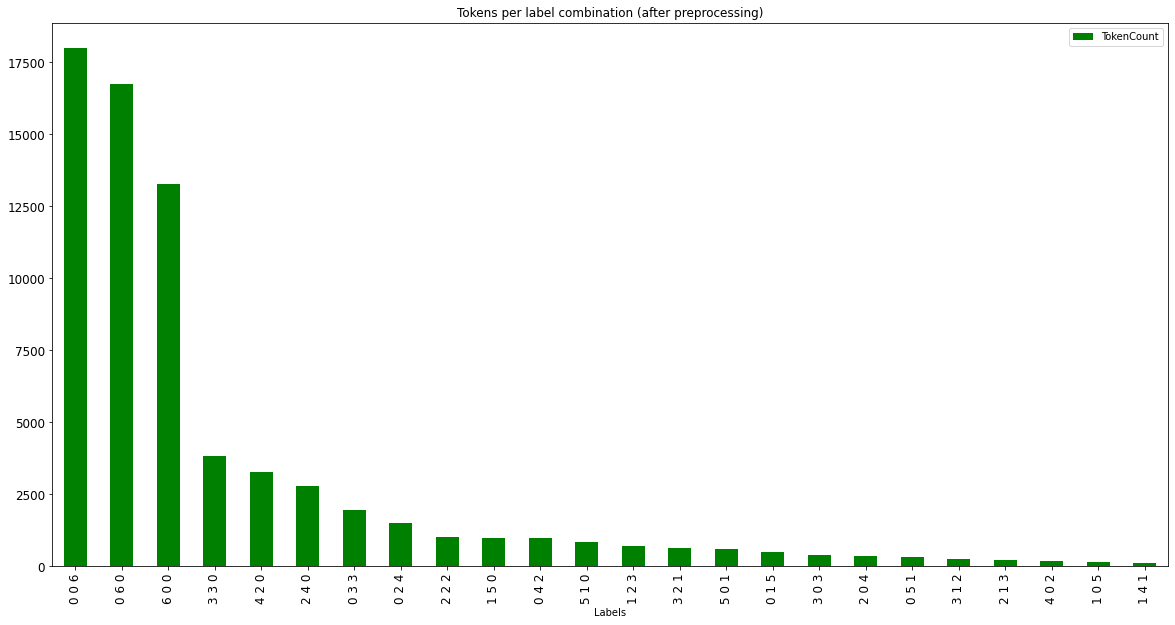

In [710]:
# Token count for each label combination after preprocessing

df['Labels'] = df['PP'].astype(str) + ' ' + df['SP'].astype(str) + ' ' + df['MC'].astype(str)
df2 = df.groupby('Labels').sum()
df2 = df2.reset_index()
df2 = df2.sort_values(by='TokenCount', ascending=False)
df2[['Labels','TokenCount']].plot(x='Labels', y='TokenCount', kind='bar', figsize=(20, 10), legend=True, fontsize=12, color='green', title='Tokens per label combination (after preprocessing)');